# PVI for Heart Attack Analysis models

In this work I will explain predictions obtained from a Random Forest model, Logistic Regression model.
Permutation-based Variable Importance (**PVI**) implementations from the Python framework `lime`. Dataset used is The
Heart Attack Analysis dataset
([source](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)).

Dataset attributes:

- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- caa: number of major vessels (0-3)
- cp : Chest Pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- oldpeak : Previous peak
- slp : Slope
- target : 0= less chance of heart attack 1= more chance of heart attack
- thall : Thalium Stress Test result [0, 3]

I have preprocessed the dataset by one hot encoding categorical features.

## Permutation-based Variable Importance for Random Forest

![](imgs/random_forest.png)

Surprisingly the most important variables according to PVI for this model are different than for the methods used
previously. Only `thall_2` (Thalium Stress Test - natural number from 0 to 3, here one hot encoded 2) has high
importance for this method and for the previous ones. It seems that changing value of a binary variable has bigger
impact on model's predictions because as we can seed from 10 most important variables only one is not a binary one.

## 3 additional models

![](imgs/random_forest_shallow.png)
![](imgs/logistic_regression.png)
![](imgs/logistic_regression_norm.png)

I have trained additional 3 following models:
- Random Forest shallow, max depth = 4
- Logistic Regression, standard data (one hot encoded)
- Logistic Regression, normalized data (min max scaler)

We can see that in the 10 most important variables of the shallow random forest are the 3 most important variables from
the previous methods, namely `oldpeak`, `thalachh` and `age` even though they do not place the highest. In case of
regression models we can clearly see that all of the most important variables are binary, I expect it is due to the fact
that regression models can easily leverage the simple domain of {0, 1} and assign high weights to this variables. for 2
regression models there are not many differences in ordering of the important variables, but there are slight
differences in magnitude of loss drop-out. Between random forest and logistic regression models there are not many
visible differences apart from the fact that PVI did not deem important any numerical variables for regression models.

## PVI vs classical tree feature importance
![](imgs/rf_feature_importances.png)

For the feature importance implemented in the `sklearn` package the 2 most important standing out variables are
`restecg_2` and `cp_2`. Regarding the former (resecg - resting electrocardiographic results from {0, 1, 2}), it is the
first time I see some form of explanation assigning it the highest importance. The later (cp - Chest Pain type from
{1, 2, 3, 4}) is highly ranked for both methods. The `age` is highly important according to feature importances which
probably means that it is often used in conditions.


## PVI vs TreeSHAP
![](imgs/tree_shap.png)

TreeShap returns results more similar to the previous methods (SHAP, LIME, PDP), as for all methods `thall_2` is very
important. 

## Appendix

### Install required packages.

In [1]:
%%capture
%pip install dalex jinja2 kaleido numpy nbformat pandas plotly torch scikit-learn shap

### Imports and loading dataset

In [2]:
import dalex as dx
import numpy as np
import pandas as pd
import plotly.express as px
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

rng = np.random.default_rng(0)

TARGET_COLUMN = "output"
df = pd.read_csv("heart.csv")
df.describe()

/home/krystian/PythonProjects/eXplainableMachineLearning-2023/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Shuffling the data, extracting target column and one hot encoding categorical columns..

In [3]:
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

y = df[[TARGET_COLUMN]]

x = df.drop(TARGET_COLUMN, axis=1)

categorical_cols = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]
numerical_cols = list(set(x.columns) - set(categorical_cols))

x = pd.get_dummies(x, columns=categorical_cols, drop_first=True)
n_columns = len(x.columns)

categorical_cols, numerical_cols

(['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'],
 ['oldpeak', 'age', 'trtbps', 'chol', 'thalachh'])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=0, shuffle=True, stratify=y)

## Random Forest models

In [5]:
model = RandomForestClassifier(random_state=0).fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [6]:
def predict_random_forest(m, d): 
    return m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, x_test, y_test, predict_function=predict_random_forest)

Preparation of a new explainer is initiated

  -> data              : 76 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 76 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_random_forest at 0x7f9add8b84c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.02, mean = 0.566, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.93, mean = -0.0266, max = 0.68
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [7]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.853659,0.795455,0.823529,0.802632,0.907317


In [8]:
def plot_pvi(explainer: dx.Explainer, save_path: str, title_suffix:str):
    pvi = explainer.model_parts(random_state=0)
    print(pvi.result)

    fig = pvi.plot(show=False).update_layout(autosize=False, width=600, height=450, title=f"Permutation-based Variable Importance {title_suffix}")
    fig.write_image(save_path)
    fig.show()

In [9]:
plot_pvi(explainer, "imgs/random_forest.png", "Random Forest Standard")

        variable  dropout_loss                   label
0            age      0.087666  RandomForestClassifier
1           chol      0.089338  RandomForestClassifier
2          slp_1      0.091672  RandomForestClassifier
3      restecg_2      0.091916  RandomForestClassifier
4        thall_1      0.092056  RandomForestClassifier
5   _full_model_      0.092683  RandomForestClassifier
6          caa_4      0.092683  RandomForestClassifier
7         trtbps      0.092962  RandomForestClassifier
8      restecg_1      0.093833  RandomForestClassifier
9          slp_2      0.094251  RandomForestClassifier
10         fbs_1      0.094390  RandomForestClassifier
11      thalachh      0.094808  RandomForestClassifier
12          cp_3      0.097317  RandomForestClassifier
13         caa_3      0.097770  RandomForestClassifier
14          cp_1      0.097840  RandomForestClassifier
15       thall_3      0.099895  RandomForestClassifier
16       oldpeak      0.102195  RandomForestClassifier
17        

Hacked way to get the same style plot of feature importances.

In [10]:
pvi = explainer.model_parts(random_state=0)
pvi.result["dropout_loss"] = pd.Series(model.feature_importances_)

fig = pvi.plot(show=False).update_layout(
    autosize=False,
    width=900,
    height=450,
    title="Random forest feature importances",
)
fig.layout["annotations"][1]["text"] = "feature importances"
fig.write_image("imgs/rf_feature_importances.png")
fig.show()

## TreeSHAP variable importance

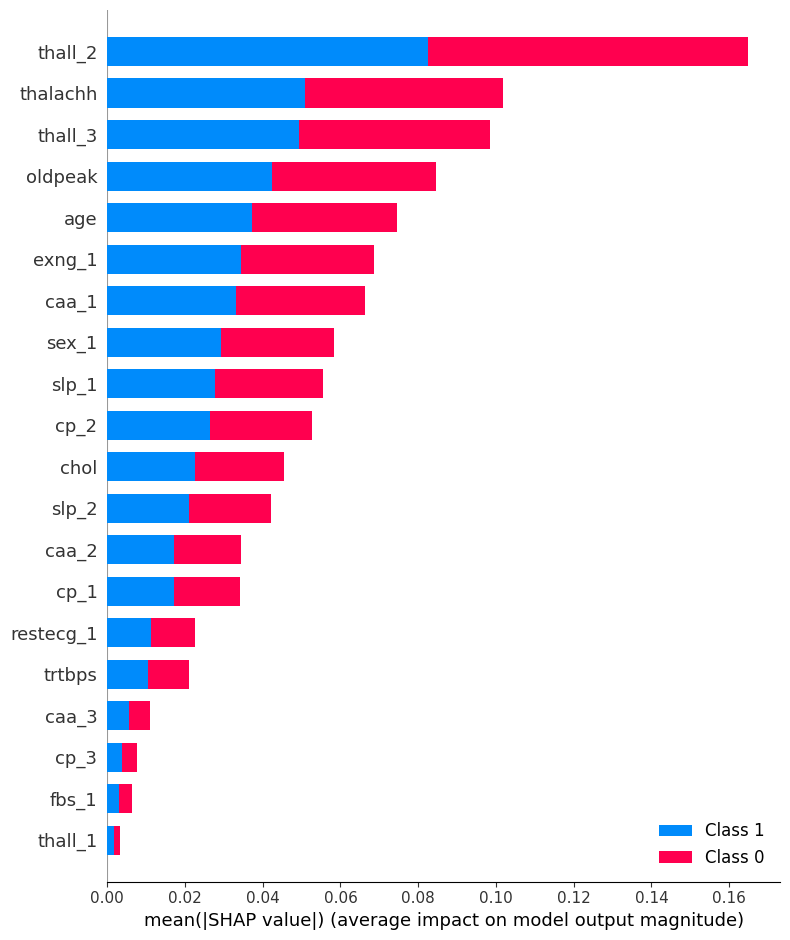

In [13]:
shap_vi = explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer", check_additivity=False)
fig = shap_vi.plot()

### Shallow Random Forest, max depth=4

In [ ]:
rf_shallow = RandomForestClassifier(random_state=0, max_depth=4).fit(x_train, y_train)
rf_shallow_explainer = dx.Explainer(rf_shallow, x_test, y_test, predict_function=predict_random_forest)
rf_shallow_explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 76 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 76 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_random_forest at 0x7f3115fcf700> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0904, mean = 0.575, max = 0.945
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.884, mean = -0.0353, max = 0.657
  -> model_info        : package sklearn

A new explainer has been created!


/tmp/ipykernel_12578/1648649002.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/krystian/PythonProjects/eXplainableMachineLearning-2023/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.853659,0.795455,0.823529,0.802632,0.913589


In [ ]:
plot_pvi(rf_shallow_explainer, "imgs/random_forest_shallow.png", "Random Forest Shallow")

        variable  dropout_loss                   label
0          slp_1      0.086132  RandomForestClassifier
1   _full_model_      0.086411  RandomForestClassifier
2          caa_4      0.086411  RandomForestClassifier
3          fbs_1      0.086620  RandomForestClassifier
4      restecg_2      0.087108  RandomForestClassifier
5          caa_3      0.087178  RandomForestClassifier
6          slp_2      0.087456  RandomForestClassifier
7        thall_1      0.087805  RandomForestClassifier
8      restecg_1      0.088223  RandomForestClassifier
9           cp_3      0.088920  RandomForestClassifier
10        trtbps      0.090105  RandomForestClassifier
11          chol      0.090732  RandomForestClassifier
12          cp_1      0.091150  RandomForestClassifier
13           age      0.091707  RandomForestClassifier
14          cp_2      0.095958  RandomForestClassifier
15      thalachh      0.096655  RandomForestClassifier
16        exng_1      0.097073  RandomForestClassifier
17        

## Logistic Regression

In [ ]:
lr_clf = RidgeClassifier(random_state=0).fit(x_train, y_train.squeeze())

In [ ]:
def lr_predict_func(m, d):
    pred = m.decision_function(d)
    return 1 / (1 + np.exp(-pred))

lr_explainer = dx.Explainer(lr_clf, x_test, y_test, predict_function=lr_predict_func)
lr_explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 76 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 76 values
  -> model_class       : sklearn.linear_model._ridge.RidgeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function lr_predict_func at 0x7f31b30a8550> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.229, mean = 0.535, max = 0.809
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.74, mean = 0.00402, max = 0.562
  -> model_info        : package sklearn

A new explainer has been created!


/home/krystian/PythonProjects/eXplainableMachineLearning-2023/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RidgeClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
RidgeClassifier,0.97561,0.869565,0.91954,0.907895,0.920557


In [ ]:
plot_pvi(lr_explainer, "imgs/logistic_regression.png", "Logistic Regression Standard")

        variable  dropout_loss            label
0         trtbps      0.071847  RidgeClassifier
1       thalachh      0.077352  RidgeClassifier
2      restecg_2      0.079303  RidgeClassifier
3         exng_1      0.079373  RidgeClassifier
4      restecg_1      0.079443  RidgeClassifier
5          caa_4      0.079443  RidgeClassifier
6   _full_model_      0.079443  RidgeClassifier
7          slp_2      0.079512  RidgeClassifier
8          fbs_1      0.079582  RidgeClassifier
9           cp_3      0.080279  RidgeClassifier
10          chol      0.080348  RidgeClassifier
11       oldpeak      0.080348  RidgeClassifier
12           age      0.080976  RidgeClassifier
13       thall_3      0.081533  RidgeClassifier
14         caa_3      0.081812  RidgeClassifier
15          cp_1      0.084460  RidgeClassifier
16       thall_1      0.084599  RidgeClassifier
17         slp_1      0.086481  RidgeClassifier
18         caa_1      0.094704  RidgeClassifier
19         sex_1      0.098188  RidgeCla

### Logistic Regression with data

In [ ]:
x_train_norm, x_test_norm = x_train.copy(), x_test.copy()

scaler = MinMaxScaler()
x_train_norm[numerical_cols] = scaler.fit_transform(x_train_norm[numerical_cols])
x_test_norm[numerical_cols] = scaler.transform(x_test_norm[numerical_cols])

In [ ]:
lr_clf_norm = RidgeClassifier(random_state=0).fit(x_train_norm, y_train.squeeze())

In [ ]:
lr_norm_explainer = dx.Explainer(lr_clf, x_test_norm, y_test, predict_function=lr_predict_func)
lr_norm_explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 76 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 76 values
  -> model_class       : sklearn.linear_model._ridge.RidgeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function lr_predict_func at 0x7f31b30a8550> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.331, mean = 0.623, max = 0.834
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.769, mean = -0.0835, max = 0.416
  -> model_info        : package sklearn

A new explainer has been created!


/home/krystian/PythonProjects/eXplainableMachineLearning-2023/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RidgeClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
RidgeClassifier,1.0,0.683333,0.811881,0.75,0.924042


In [ ]:
plot_pvi(lr_norm_explainer, "imgs/logistic_regression_norm.png", "Logistic Regression Normalized")

        variable  dropout_loss            label
0      restecg_2      0.073728  RidgeClassifier
1          fbs_1      0.074564  RidgeClassifier
2          slp_2      0.074843  RidgeClassifier
3        thall_3      0.075610  RidgeClassifier
4            age      0.075819  RidgeClassifier
5   _full_model_      0.075958  RidgeClassifier
6          caa_4      0.075958  RidgeClassifier
7       thalachh      0.076167  RidgeClassifier
8           chol      0.076167  RidgeClassifier
9         trtbps      0.076237  RidgeClassifier
10       thall_1      0.077003  RidgeClassifier
11     restecg_1      0.077143  RidgeClassifier
12       oldpeak      0.077422  RidgeClassifier
13        exng_1      0.085017  RidgeClassifier
14          cp_3      0.085784  RidgeClassifier
15         caa_3      0.088780  RidgeClassifier
16         caa_1      0.101324  RidgeClassifier
17         slp_1      0.102787  RidgeClassifier
18          cp_1      0.104808  RidgeClassifier
19         sex_1      0.109756  RidgeCla